[사용자 정의 dataloader 작성하기](https://tutorials.pytorch.kr/recipes/recipes/custom_dataset_transforms_loader.html)

학습 목표

1. PyTorch 데이터셋 API이용해 __사용자 정의 데이터셋__ 만들기
2. 사용자 정의 __transform__ 만들기
3. 1과 2를 합쳐서 사용자 정의 __dataloader__ 만들기

필요한 패키지 (colab에는 이미 존재)\
`scikit-image` : 이미지 I/O, transform\
`pandas` : CSV 파싱

### Setup

In [1]:
# 라이브러리 불러오기

from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import warnings

# 경고 메시지 무시
warnings.filterwarnings("ignore")

# 반응형 모드 설정(interactive on) -> default
plt.ion()

### 1. 데이터셋

얼굴 포즈 데이터셋

한 얼굴에 68개의 랜드마크 존재

[데이터셋](https://download.pytorch.org/tutorial/faces.zip) 다운로드 후 <u>data/faces/</u> 경로에 위치하게 한다.



In [3]:
!wget https://download.pytorch.org/tutorial/faces.zip
# !mkdir /data/faces/
from os import path
import zipfile

if not path.exists('/data/faces'):
    os.makedirs('/data/faces')

with zipfile.ZipFile("faces.zip","r") as zip_ref:
    zip_ref.extractall("/data/faces/")
%cd /data/faces/

--2023-07-13 13:46:53--  https://download.pytorch.org/tutorial/faces.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.84.252.12, 99.84.252.41, 99.84.252.122, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.84.252.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5780252 (5.5M) [application/zip]
Saving to: ‘faces.zip.1’

faces.zip.1         100%[===================>]   5.51M  26.9MB/s    in 0.2s    

2023-07-13 13:46:54 (26.9 MB/s) - ‘faces.zip.1’ saved [5780252/5780252]

/data/faces


In [4]:
# CSV 파일 읽기

landmarks_frame = pd.read_csv('faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks)
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


#### 1.1 이미지 표시 위한 도움 함수 작성

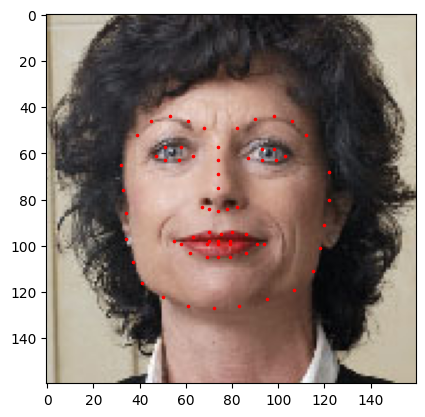

In [15]:
# 이미지가 가지고 있는 랜드마크 및 이미지 샘플 보여주기

def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(
        landmarks[:, 0],
        landmarks[:, 1],
        s=10,
        marker='.',
        c='r'
    )

plt.figure()
show_landmarks(io.imread(os.path.join('faces/', img_name)), landmarks)
plt.show()

#### 1.2 데이터셋 클래스 생성

`torch.utils.data.Dataset`: 추상 클래스, 데이터셋을 맡고 있다. `Dataset`을 상속받아야 하며 아래의 메소드들을 오버라이드 해야 한다

* `__len__` : `len(dataset)` 반환해야 함
* `__getitem__` : `dataset[i]` 의 샘플을 얻기 위해 사용된다

아래의 실습

> csv 파일은 `__init__` 에서 읽고\
> 이미지들은 `__getitem__` 에서 읽기\
> -> 이미지를 메모리에 저장하지 않고 필요할 때마다 불러오기 위함

In [6]:
class FaceLandMarksDataset(Dataset):
    def __init__(
        self,
        csv_file,
        root_dir,
        transform=None,
    ):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(
        self,
        idx,
    ):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(
            self.root_dir,
            self.landmarks_frame.iloc[idx, 0],
        )
        image = io.imread(img_name)

        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

#### 1.3 반복문을 통한 데이터 샘플 사용

0 (324, 215, 3) (68, 2)
1 (500, 333, 3) (68, 2)
2 (250, 258, 3) (68, 2)
3 (434, 290, 3) (68, 2)


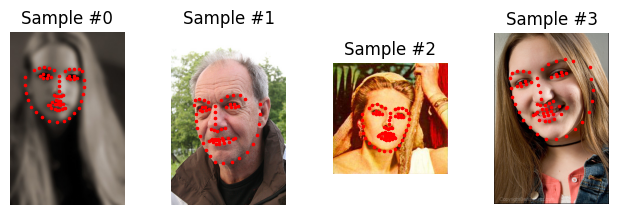

In [7]:
face_dataset = FaceLandMarksDataset(
    csv_file='faces/face_landmarks.csv',
    root_dir='faces/',
)

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

### 2. 데이터 변형

* rescale: 이미지 크기 변경
* randomcrop: 무작위로 이미지 잘라내기, 데이터 증강에 사용
* ToTensor: Numpy 이미지를 파이토치 이미지로 변환

위 3개의 변형들을 호출 가능한 클래스로 만들어서 매번 변형이 호출될 때 항상 매개변수가 넘겨지지 않돌고 한다.

예)

```python
tsfm = Transform(params)
transformed_sample = tsfm(sample)
```

#### 2.1 호출 가능한 클래스들 작성

In [9]:
class Rescale(object):
    """주어진 크기로 샘플 안의 이미지를 재변환

    Args:
        output_size(Union[Tuple, int]): 원하는 결과값의 크기
            tuple: 결과값은 output_size와 동일
            int: 설정된 값보다 작은 이미지들의 가로와 세로가
                 output_size에 적절한 비율로 변환됨
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h = new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h와 w는 이미지의 랜드마크들 때문에 서로 바뀐다
        # x와 y 축들은 각각 1과 0 값을 가짐

        landmarks = landmarks * [new_w / w, new_h / h]
        return {'image': img, 'landmarks': landmarks}

class RandomCrop(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}

class ToTensor(object):
    """ 샘플 안의 n차원 배열을 Tensor로 변환
    """

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # numpy와 torch의 이미지 표현 방식에 차이 존재 -> 축 변경해야 함
        # numpy: H x W x C
        # torch: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

#### 2.2 변환들을 구성하고 샘플에 적용하기

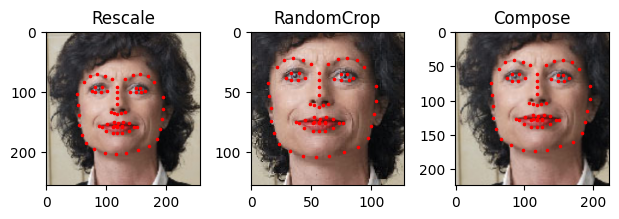

In [17]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

# 변환들 적용시키기
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)

    # figure의 크기는 변화시키지 않은 채 여백을 만들기
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

#### 2.3 데이터셋을 반복문을 통해 사용하기

데이터셋 불러오기
* 이미지는 읽으려고 할 때마다 불러옴
* 변형들은 읽은 이미지에 적용됨
* 변형들 중 하나는 무작위 $→$ 샘플링에 따라 데이터가 증강됨

In [10]:
transformed_dataset = FaceLandMarksDataset(
    csv_file='faces/face_landmarks.csv',
    root_dir='faces/',
    transform=transforms.Compose([
        Rescale(256),
        RandomCrop(224),
        ToTensor()
    ])
)

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


In [11]:
dataset = FaceLandMarksDataset(
    csv_file='faces/face_landmarks.csv',
    root_dir='faces/',
)

### 3. DataLoader

단순 `for` 반복문을 사용하지 말고 DataLoader를 사용, 아래의 특성들을 이용하기
1. 데이터 배치
2. 데이터 섞기
3. `multiprocessing` $→$ 병렬적으로 데이터 불러오기

`torch.utils.data.DataLoader` 사용하기

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


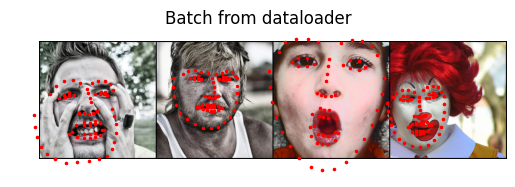

In [18]:
dataloader = DataLoader(
    transformed_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4
)

# 배치를 보여주기 위한 도움 함수
def show_landmarks_batch(sample_batched):
    """샘플들의 배치에서 이미지와 함께 랜드마크 보여줌
    """
    images_batch, landmarks_batch = \
        sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    # 이미지 출력을 위함
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(
            landmarks_batch[i, :, 0].numpy() + i * im_size,
            landmarks_batch[i, :, 1].numpy(),
            s=10, marker='.', c='r'
        )
        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
            sample_batched['landmarks'].size())

    # 4번째 배치에서 반복문 종료
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break